## Unsupervised Models 

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_recall_curve, auc, roc_curve, make_scorer
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

# Import your existing utility module
import credit_card_fraud_utils as ccf

In [2]:
# Initialize configuration
config = ccf.Config()

# You can modify config parameters here if needed
# config.IF_CONTAMINATION = 0.02
# config.LOF_N_NEIGHBORS = 25

# Display default configuration
print("Configuration Parameters:")
for attr, value in config.__dict__.items():
    print(f"{attr} = {value}")

Configuration Parameters:


In [3]:
# Load the dataset
df = ccf.load_data(config)

# Display basic information
print(f"Dataset Shape: {df.shape}")
print(f"Number of Transactions: {df.shape[0]}")
print(f"Number of Features: {df.shape[1]}")

# Display the first few rows
df.head()

Dataset Shape: (284807, 31)
Number of Transactions: 284807
Number of Features: 31


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# Get a summary of the dataset
summary = ccf.get_data_summary(df)

print(f"Missing Values: {summary['missing_values']}")
print(f"Normal Transactions: {summary['normal_count']} ({100 - summary['fraud_percentage']:.2f}%)")
print(f"Fraudulent Transactions: {summary['fraud_count']} ({summary['fraud_percentage']:.2f}%)")

# Based on the actual fraud percentage, we might want to update the contamination parameter
print(f"\nRecommended contamination value: {summary['fraud_percentage'] / 100:.6f}")
config.IF_CONTAMINATION = summary['fraud_percentage'] / 100
config.LOF_CONTAMINATION = summary['fraud_percentage'] / 100

Missing Values: 0
Normal Transactions: 284315 (99.83%)
Fraudulent Transactions: 492 (0.17%)

Recommended contamination value: 0.001727


In [5]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Class'])
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

#scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### Isolation Forest

In [6]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



model = IsolationForest(contamination=0.001727, random_state=42, n_estimators=100, max_samples='auto')
model.fit(X_train)
y_pred = model.predict(X_test)

# Convert predictions from (-1, 1) to (0, 1) format
y_pred = np.where(y_pred == -1, 1, 0)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')


print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auprc = auc(recall, precision)
print(f"AUPRC: {auprc:.4f}")

Accuracy: 0.9977
Precision: 0.3300
Recall: 0.3367
F1-score: 0.3333
AUPRC: 0.3339


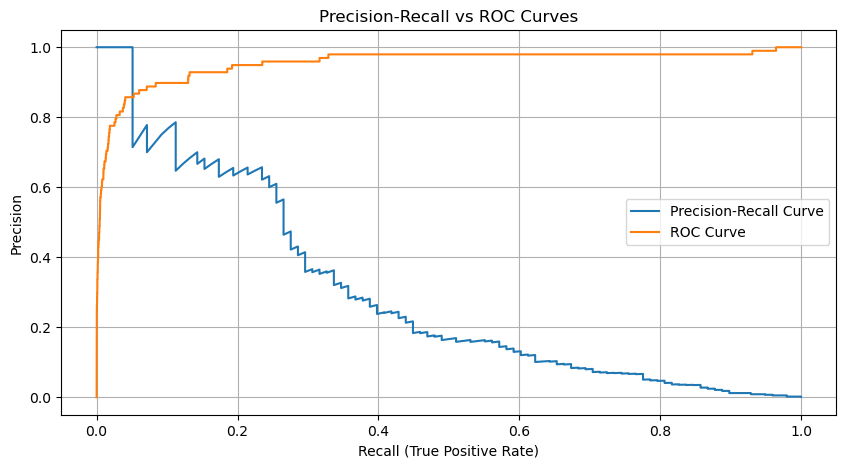

In [7]:
# Get anomaly scores (the lower the score, the more likely it's an outlier)
y_scores = -model.score_samples(X_test)  # Negative because lower scores mean more anomalous

# Get binary predictions for metrics
y_pred = model.predict(X_test)
y_pred = np.where(y_pred == -1, 1, 0)  # Convert to 0/1 format

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_scores)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores)

# Plot both curves
plt.figure(figsize=(10, 5))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('Recall (True Positive Rate)')
plt.ylabel('Precision')
plt.title('Precision-Recall vs ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix, matthews_corrcoef, roc_curve, precision_recall_curve

def calculate_recall_at_fpr(y_true, y_scores, k=0.005):
    """Calculate recall at a specific false positive rate."""
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    idx = np.argmin(np.abs(fpr - k))
    return tpr[idx]

def calculate_precision_at_recall(y_true, y_scores, k=0.005):
    """Calculate precision at a specific recall rate."""
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    idx = np.argmin(np.abs(recall - k))
    return precision[idx]

def calculate_ks_statistic(y_true, y_scores):
    """Calculate Kolmogorov-Smirnov statistic."""
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    return np.max(np.abs(fpr - tpr))

# Now calculate the metrics
cm = confusion_matrix(y_test, y_pred)
recall_at_k = calculate_recall_at_fpr(y_test, y_scores, k=0.005)
precision_at_k = calculate_precision_at_recall(y_test, y_scores, k=0.005)
mcc = matthews_corrcoef(y_test, y_pred)
ks = calculate_ks_statistic(y_test, y_scores)

print(f"Confusion Matrix:\n{cm}")
print(f"Recall at 0.5% FPR: {recall_at_k:.4f}")
print(f"Precision at 0.5% Recall: {precision_at_k:.4f}")
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print(f"Kolmogorov-Smirnov Statistic: {ks:.4f}")

Confusion Matrix:
[[56797    67]
 [   65    33]]
Recall at 0.5% FPR: 0.5510
Precision at 0.5% Recall: 1.0000
Matthews Correlation Coefficient: 0.3322
Kolmogorov-Smirnov Statistic: 0.8172


In [9]:
#gridsearch
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest

# Define the parameter grid
param_grid = {
    'n_estimators': [20, 30, 40, 50, 60, 70],
    'max_samples': ['auto', 0.5, 1.0],
    'contamination': [0.0001,0.0005, 0.001, 0.005, 0.01],
    'random_state': [42]
}

# Initialize the Isolation Forest model
if_model = IsolationForest(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=if_model, param_grid=param_grid, cv=5, scoring='average_precision')

# Fit the grid search to the training data
grid_search.fit(X_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_if_model = grid_search.best_estimator_


In [16]:
#best_if_model.save('best_if_model.pkl')
best_params

{'contamination': 0.0001,
 'max_samples': 'auto',
 'n_estimators': 20,
 'random_state': 42}

In [17]:
y_pred = best_if_model.predict(X_test)

# Convert predictions from (-1, 1) to (0, 1) format
y_pred = np.where(y_pred == -1, 1, 0)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')


print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auprc = auc(recall, precision)
print(f"AUPRC: {auprc:.4f}")

Accuracy: 0.9982
Precision: 0.3333
Recall: 0.0204
F1-score: 0.0385
AUPRC: 0.1777


In [18]:
# Get anomaly scores (the lower the score, the more likely it's an outlier)
y_scores = -best_if_model.score_samples(X_test)  # Negative because lower scores mean more anomalous

# Get binary predictions for metrics
y_pred = best_if_model.predict(X_test)
y_pred = np.where(y_pred == -1, 1, 0)  # Convert to 0/1 format

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_scores)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores)


# Now calculate the metrics
cm = confusion_matrix(y_test, y_pred)
recall_at_k = calculate_recall_at_fpr(y_test, y_scores, k=0.005)
precision_at_k = calculate_precision_at_recall(y_test, y_scores, k=0.005)
mcc = matthews_corrcoef(y_test, y_pred)
ks = calculate_ks_statistic(y_test, y_scores)

print(f"Confusion Matrix:\n{cm}")
print(f"Recall at 0.5% FPR: {recall_at_k:.4f}")
print(f"Precision at 0.5% Recall: {precision_at_k:.4f}")
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print(f"Kolmogorov-Smirnov Statistic: {ks:.4f}")



Confusion Matrix:
[[56860     4]
 [   96     2]]
Recall at 0.5% FPR: 0.5714
Precision at 0.5% Recall: 0.0000
Matthews Correlation Coefficient: 0.0821
Kolmogorov-Smirnov Statistic: 0.8354


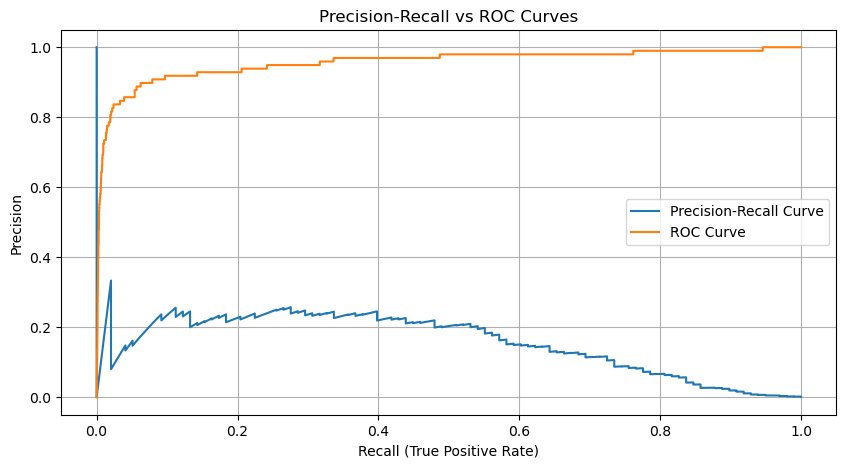

In [19]:

# Plot both curves
plt.figure(figsize=(10, 5))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('Recall (True Positive Rate)')
plt.ylabel('Precision')
plt.title('Precision-Recall vs ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

### Local Outlier Factor

In [14]:
from sklearn.neighbors import LocalOutlierFactor

model_lof   = LocalOutlierFactor(contamination=0.001727)
model_lof.fit(X_train)
y_pred = model_lof.predict(X_test)

# Convert predictions from (-1, 1) to (0, 1) format
y_pred = np.where(y_pred == -1, 1, 0)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')


print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auprc = auc(recall, precision)
print(f"AUPRC: {auprc:.4f}")

AttributeError: This 'LocalOutlierFactor' has no attribute 'predict'

In [ ]:
# Train Isolation Forest model
print("Training Isolation Forest model...")
if_model = ccf.train_isolation_forest(X_train, config)
if_preds, if_scores = ccf.get_model_predictions(if_model, X_test)

In [ ]:
# Train Local Outlier Factor model
print("Training Local Outlier Factor model...")
lof_model = ccf.train_lof(X_train, config)
lof_preds, lof_scores = ccf.get_model_predictions(lof_model, X_test, is_isolation_forest=False)

In [ ]:
# Evaluate Isolation Forest
if_metrics = ccf.calculate_metrics(y_test, if_preds, if_scores)
print("Isolation Forest Results:")
print(f"Accuracy: {if_metrics['accuracy']:.4f}")
print("\nConfusion Matrix:")
print(if_metrics['confusion_matrix'])
print("\nClassification Report:")
print(if_metrics['classification_report'])

In [ ]:
# Evaluate LOF
lof_metrics = ccf.calculate_metrics(y_test, lof_preds, lof_scores)
print("Local Outlier Factor Results:")
print(f"Accuracy: {lof_metrics['accuracy']:.4f}")
print("\nConfusion Matrix:")
print(lof_metrics['confusion_matrix'])
print("\nClassification Report:")
print(lof_metrics['classification_report'])

In [ ]:
# Plot ROC curves
plt_roc, auc_if, auc_lof = ccf.plot_roc_curves(y_test, if_scores, lof_scores)
plt_roc.show()

In [ ]:
# Plot Precision-Recall curves
plt_pr = ccf.plot_pr_curves(y_test, if_scores, lof_scores)
plt_pr.show()

In [ ]:
# Plot anomaly score distributions
plt_scores, eval_df = ccf.plot_anomaly_scores(if_scores, lof_scores, y_test)
plt_scores.show()

In [ ]:
# Plot anomaly score comparison
plt_comparison = ccf.plot_score_comparison(eval_df)
plt_comparison.show()

In [ ]:
# Compare model performance
comparisons = ccf.compare_models(y_test, if_preds, lof_preds, if_scores, lof_scores, auc_if, auc_lof)
print("Model Comparison:")
comparisons.style.highlight_max(axis=0)